# Emotion classification multiclass example

This notebook demonstrates how to use the `Partition` explainer for a multiclass text classification scenario. Once the SHAP values are computed for a set of sentences we then visualize feature attributions towards individual classes. The text classifcation model we use is BERT fine-tuned on an emotion dataset to classify a sentence among six classes: joy, sadness, anger, fear, love and surprise.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import transformers
import datasets
import shap

# load the emotion dataset
dataset  = datasets.load_dataset("emotion", split = "train")
data = pd.DataFrame({'text':dataset['text'],'emotion':dataset['label']})

Using custom data configuration default


Dataset emotion downloaded and prepared to C:\Users\Parth.chokhra\.cache\huggingface\datasets\emotion\default\0.0.0\348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


### Build a transformers pipline

Note that we have set `return_all_scores=True` for the pipeline so we can observe the model's behavior for all classes, not just the top output.

In [4]:
# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion", use_fast=True)
model = transformers.AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion")

# build a pipeline object to do predictions
pred = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

### Create an explainer for the pipeline

A transformers pipeline object can be passed directly to `shap.Explainer`, which will then wrap the pipeline model as a `shap.models.TransformersPipeline` model and the pipeline tokenizer as a `shap.maskers.Text` masker.

In [5]:
explainer = shap.Explainer(pred)

### Compute SHAP values

Explainers have the same method signature as the models they are explaining, so we just pass a list of strings for which to explain the classifications.

In [6]:
shap_values = explainer(data['text'][:3])

Partition explainer: 4it [00:21, 10.53s/it]               


### Visualize the impact on all the output classes

In the plots below, when you hover your mouse over an output class you get the explanation for that output class. When you click an output class name then that class remains the focus of the explanation visualization until you click another class.

The base value is what the model outputs when the entire input text is masked, while $f_{output class}(inputs)$ is the output of the model for the full original input. The SHAP values explain in an addive way how the impact of unmasking each word changes the model output from the base value (where the entire input is masked) to the final prediction value.

In [7]:
shap.plots.text(shap_values)

### Visualize the impact on a single class

Since `Explanation` objects are sliceable we can slice out just a single output class to visualize the model output towards that class.

In [8]:
shap.plots.text(shap_values[:, :, "anger"])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Plotting the top words impacting a specific class

In addition to slicing, `Explanation` objects also support a set of reducing methods. Here we use the `.mean(0)` to take the average impact of all words towards the "joy" class. Note that here we are also averaging over three examples, to get a better summary you would want to use a larger portion of the dataset.

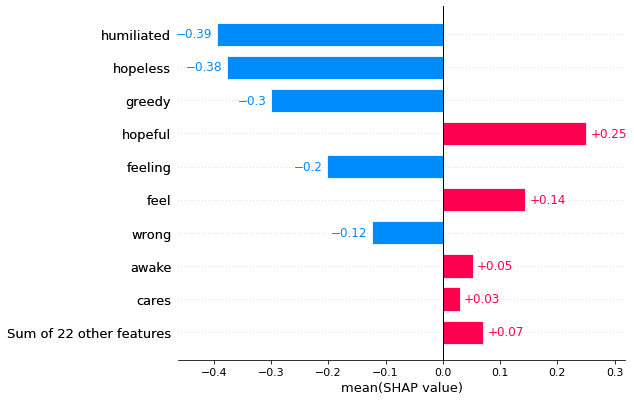

In [9]:
shap.plots.bar(shap_values[:,:,"joy"].mean(0))

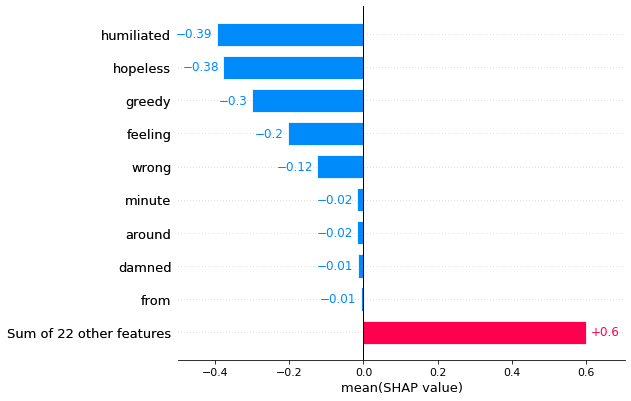

In [10]:
# we can sort the bar chart in decending order
shap.plots.bar(shap_values[:,:,"joy"].mean(0), order=shap.Explanation.argsort)

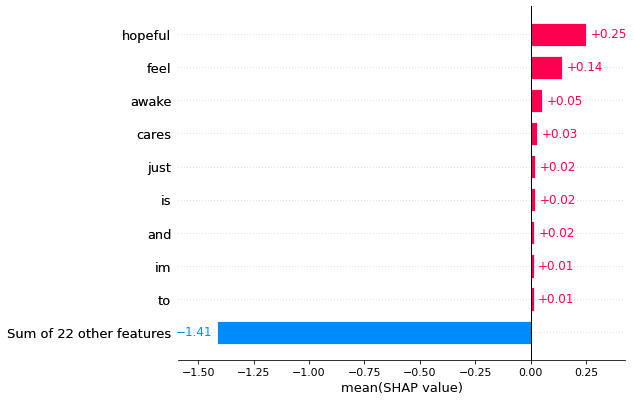

In [11]:
# ...or acending order
shap.plots.bar(shap_values[:,:,"joy"].mean(0), order=shap.Explanation.argsort.flip)

### Explain the log odds instead of the probabilities

In the examples above we explained the direct output of the pipline object, which are class probabilities. Sometimes it makes more sense to work in a log odds space where it is natural to add and subtract effects (addition and subtraction correspond to the addition or subtraction of bits of evidence information). To work with logits we can use a parameter of the `shap.models.TransformersPipeline` object:

In [15]:
logit_explainer = shap.Explainer(shap.models.TransformersPipeline(pred, rescale_to_logits=True))

logit_shap_values = logit_explainer(data['text'][:3])
shap.plots.text(logit_shap_values)

<hr>
Have an idea for more helpful examples? Pull requests that add to this documentation notebook are encouraged! 